Initialize spark context 

In [2]:
from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans
spark = SparkSession.builder.appName('cluster').getOrCreate()

Read data from file

In [ ]:
df =spark.read.csv('hack_data.csv',inferSchema=True,header=True)

Import libraries for graph visulization

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Read data to panda library for visualization

In [32]:
df_cl = pd.read_csv(r"C:\Users\Vimal\hack_data.csv")

Print scema of dataframe

In [34]:
df.printSchema()

root
 |-- Session_Connection_Time: double (nullable = true)
 |-- Bytes Transferred: double (nullable = true)
 |-- Kali_Trace_Used: integer (nullable = true)
 |-- Servers_Corrupted: double (nullable = true)
 |-- Pages_Corrupted: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- WPM_Typing_Speed: double (nullable = true)



Print column structure of dataframe

In [3]:
df.head()

Row(Session_Connection_Time=8.0, Bytes Transferred=391.09, Kali_Trace_Used=1, Servers_Corrupted=2.96, Pages_Corrupted=7.0, Location='Slovenia', WPM_Typing_Speed=72.37)

Print data from dataframe

In [4]:
df.describe().show()

+-------+-----------------------+------------------+------------------+-----------------+------------------+-----------+------------------+
|summary|Session_Connection_Time| Bytes Transferred|   Kali_Trace_Used|Servers_Corrupted|   Pages_Corrupted|   Location|  WPM_Typing_Speed|
+-------+-----------------------+------------------+------------------+-----------------+------------------+-----------+------------------+
|  count|                    334|               334|               334|              334|               334|        334|               334|
|   mean|     30.008982035928145| 607.2452694610777|0.5119760479041916|5.258502994011977|10.838323353293413|       null|57.342395209580864|
| stddev|     14.088200614636158|286.33593163576757|0.5006065264451406| 2.30190693339697|  3.06352633036022|       null| 13.41106336843464|
|    min|                    1.0|              10.0|                 0|              1.0|               6.0|Afghanistan|              40.0|
|    max|           

In [5]:
df.columns

['Session_Connection_Time',
 'Bytes Transferred',
 'Kali_Trace_Used',
 'Servers_Corrupted',
 'Pages_Corrupted',
 'Location',
 'WPM_Typing_Speed']

#### Plot graph

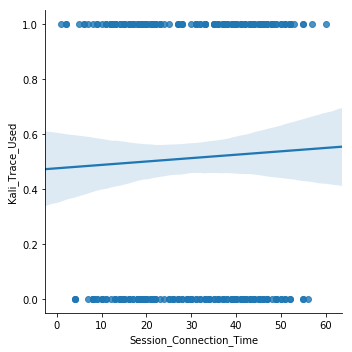

In [33]:
sns.lmplot(x='Session_Connection_Time', y='Kali_Trace_Used', data= df_cl)

In [36]:
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int' or t[1] == 'double']

In [37]:
corr = df.select(numeric_features).sample(False, 0.10).toPandas()

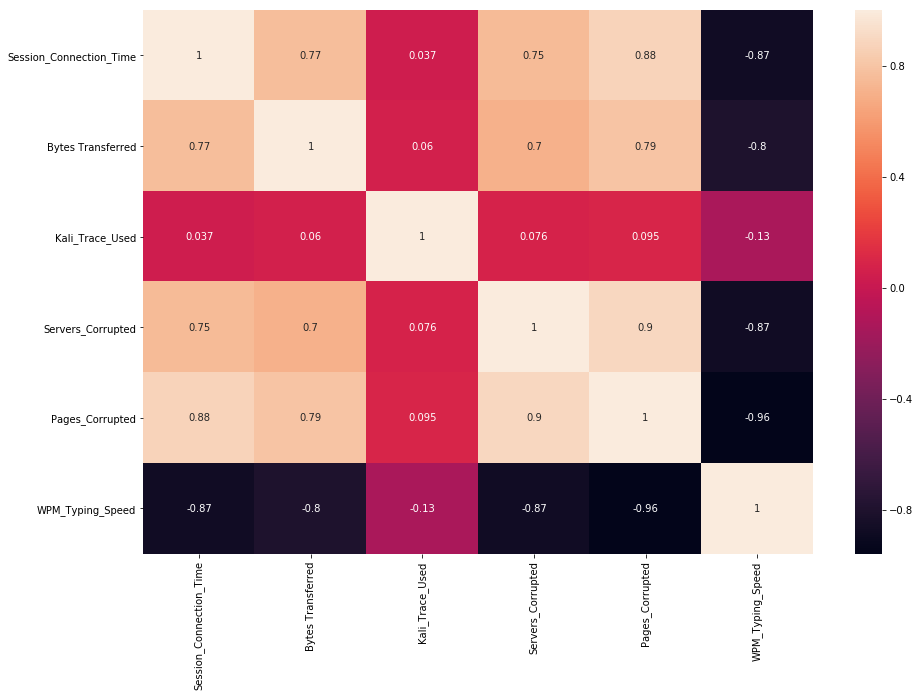

In [39]:
heatmap = sns.heatmap(data= corr.corr(), annot=True)
heatmap.figure.set_size_inches(15,10)

### Format data

In [4]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [5]:
clust_features = ['Session_Connection_Time', 'Bytes Transferred', 'Kali_Trace_Used',
             'Servers_Corrupted', 'Pages_Corrupted','WPM_Typing_Speed']

In [6]:
vec_assembler = VectorAssembler(inputCols = clust_features, outputCol='features')

In [7]:
final_data = vec_assembler.transform(df)

### Scale Data

In [8]:
from pyspark.ml.feature import StandardScaler

In [9]:
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)

In [10]:
scalerModel = scaler.fit(final_data)

In [11]:
clust_final_data = scalerModel.transform(final_data)

### We need to find that the third hacker hacker is involved or not so we consider k = 2 and k = 3


In [12]:
k2 = KMeans(featuresCol='scaledFeatures',k=2)
k3 = KMeans(featuresCol='scaledFeatures',k=3)

In [13]:
k2_model = k2.fit(clust_final_data)
k3_model = k3.fit(clust_final_data)

In [14]:
wssse_2 = k2_model.computeCost(clust_final_data)
wssse_3 = k3_model.computeCost(clust_final_data)

In [15]:
print("Within Set Sum of Squared Errors for k = 2 is " + str(wssse_2))

print("Within Set Sum of Squared Errors for k = 3 is " + str(wssse_3))


Within Set Sum of Squared Errors for k = 2 is 601.7707512676716
Within Set Sum of Squared Errors for k = 3 is 434.75507308487647


In [16]:
centers = k2_model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[2.99991988 2.92319035 1.05261534 3.20390443 4.51321315 3.28474   ]
[1.26023837 1.31829808 0.99280765 1.36491885 2.5625043  5.26676612]


In [17]:
centers = k3_model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[1.26023837 1.31829808 0.99280765 1.36491885 2.5625043  5.26676612]
[3.05623261 2.95754486 1.99757683 3.2079628  4.49941976 3.26738378]
[2.93719177 2.88492202 0.         3.19938371 4.52857793 3.30407351]


In [18]:
k2_model.transform(clust_final_data).select('prediction').show()

+----------+
|prediction|
+----------+
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
+----------+
only showing top 20 rows



In [19]:
k3_model.transform(clust_final_data).select('prediction').show()

+----------+
|prediction|
+----------+
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
+----------+
only showing top 20 rows



#### Now we can find the similarity between the count of prediction for both cases. If prediction count is similar for all values of k = 3 then the third hacker is involved.


In [20]:
k2_model.transform(clust_final_data).groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|  167|
|         0|  167|
+----------+-----+



In [21]:
k3_model.transform(clust_final_data).groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|   88|
|         2|   79|
|         0|  167|
+----------+-----+



#### Here we can see that the count of predictions is different for prediction 0 value and almost similar for 1 and 2. for cluster 2, they are equally sized and  therefore we can conclude that the third hacker was not involved.